# Comparative Analysis of ConvNet Architecture on Bird Species Dataset



 ## Load necessary libraries
 
The libraries that you need to install are listed on the Requirements.txt file.

In [49]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math

#For modeling and model viewing. 
import tensorflow as tf
from keras.regularizers import l2
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
from sklearn.metrics import confusion_matrix



## ConvNet models

We need to import some of the existing CNN models; keep in mind that some of them are pre-trained and need to download some data first.

In [49]:
from tensorflow.keras.applications import VGG16, VGG19, MobileNet, ResNet152V2, InceptionV3
from keras.applications.vgg16 import preprocess_input

## process the data

Input data is in 3 different directories:


└──── input

         ├── test
         ├── valid
         └── train
         

Also, in each of these 3 folders, 250 folders are containing the type of the bird and the respective number of images that I mentioned in README.md file.

In [4]:
DIR = r'C:\\Users\\LENOVO\\Documents\\GitHub\\Comparative-Analysis-of-ConvNet-Architecture-on-Bird-Species-Dataset\\input'
print('base directory contains ', os.listdir(DIR))
train_DIR = os.path.join(DIR, 'train')
validation_DIR = os.path.join(DIR, 'valid')
test_DIR = os.path.join(DIR, 'test')

base directory contains  ['consolidated', 'test', 'train', 'valid']


In [6]:
#This will establish the prediction groups for the model.

categories = os.listdir(train_DIR)

category_count = len(categories)

print("There are {} categories in this dataset.".format(category_count))
print("List of 20 random categories : ")

[category for category in random.sample(categories, 20)] # Prints 20 directory names randomly

There are 250 categories in this dataset.
List of 20 random categories : 


['BEARDED BARBET',
 'BLACK-CAPPED CHICKADEE',
 'HORNED GUAN',
 'STEAMER DUCK',
 'SPLENDID WREN',
 'GREATOR SAGE GROUSE',
 'YELLOW HEADED BLACKBIRD',
 'MALLARD DUCK',
 'RUBY THROATED HUMMINGBIRD',
 'MARABOU STORK',
 'JAVAN MAGPIE',
 'SPANGLED COTINGA',
 'WHITE TAILED TROPIC',
 'PURPLE SWAMPHEN',
 'GOLDEN EAGLE',
 'JABIRU',
 'GRAY PARTRIDGE',
 'KING VULTURE',
 'ROSY FACED LOVEBIRD',
 'CRESTED NUTHATCH']

For convenience, I plotted out one of the funny-looking birds to analyze its image shape and properties.

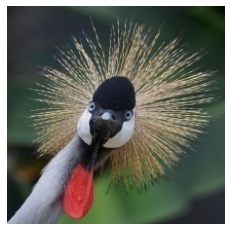

Figures are  (224, 224, 3)


In [43]:
#Load an image and determine image shape for analysis.
image = load_img(os.path.join(train_DIR, r'AFRICAN CROWNED CRANE\013.jpg'))
plt.imshow(image)
plt.axis("off")
plt.show()

imagedata = img_to_array(image)
shape = imagedata.shape
print('Figures are ', shape)


## Loading the training data

I created an "ImageDataGenerator" which is mostly used for data augmentation, but here I just rescaled the values from 0-255 to 0-1 for better computation processing, and also, it's pretty convenient to load the data from this object using "flow_from_directory" command.

In [27]:
#This will be used on training, test, and valid data
data_generator = ImageDataGenerator(rescale=1./255, )

In [31]:
train_data = data_generator.flow_from_directory(train_DIR, target_size=(224,224), batch_size=16)
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
train_groups = len(train_data)
validation_data = data_generator.flow_from_directory(validation_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
valid_groups = len(validation_data)
test_data = data_generator.flow_from_directory(test_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 35215 images belonging to 250 classes.
data groups: 2201
Found 1250 images belonging to 250 classes.
data groups: 40
validation image qty: 1250
Found 1250 images belonging to 250 classes.
data groups: 40


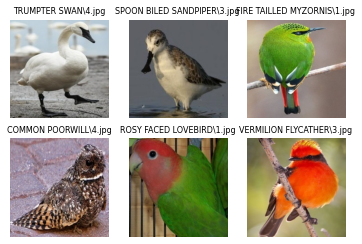

In [32]:
#create seperate labels for images 
def label_images(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images(test_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)

plt.show()

# Modeling

After loading all the data, we need and defining the proper variables. It's time to use a model to train the data.

In this notebook, I will use several models to compare their performance on this particular dataset. By analyzing this model's history and background, I can guess how well and in which sequence these models will perform. So I try to train these models in an accending accuracy order
. 

## AlexNet 2012 ( ~72% accuracy)


In [36]:
backend.clear_session()
model = Sequential()

# Layer 1
model.add(Conv2D(64, (3, 3), padding='same',input_shape=shape)) #224X224
model.add(Activation('relu'))
model.add(BatchNormalization())

# Layer 2
model.add(Conv2D(64, (3, 3))) #222x222
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #111x111
model.add(BatchNormalization())

# Layer 3
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization()) 


# Layer 4
model.add(Conv2D(64, (3, 3))) #109x109
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #54x54
model.add(BatchNormalization())
model.add(Dropout(0.35)) #64 --> 42

# Layer 5
model.add(Conv2D(64, (3, 3), padding='same')) #54x54
model.add(Activation('relu'))
model.add(BatchNormalization())

# Layer 6
model.add(Conv2D(64, (3, 3), padding='same')) #54x54
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #27x27
model.add(BatchNormalization())

# Layer 7
model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512)) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(category_count)) #Updated for number of classes
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator(
    train_data, 
    steps_per_epoch = train_groups, 
    epochs = 4,
    validation_data = validation_data,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, 
                                 patience = 2, verbose = 1)])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 64)      2

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# VGG16 - 2014 ( ~86% accuracy)


In [ ]:
#Let's try the vgg16 - 86% accuracy
#Initial run with 2 epochs est loss: 27.959821766820447, Test accuracy: 0.40666667
# Increased to 50 epochs to Test loss: 26.42553789862271, Test accuracy: 0.79888886 - 80%
# Added pooling Max to the vgg16 model -78%
# Removedpooling and add sgd in place of adam optimizer: Test loss: 0.5881293734599804, Test accuracy: 0.8611111
backend.clear_session()


#Bring in the imagenet dataset training weights for the VGG16 CNN model, remove the classification, the default shape is correct (3,224,224) for my purposes.
base_vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = shape)
base_vgg16.trainable = False # Freeze the VGG16 weights.

model = Sequential()
model.add(base_vgg16)

model.add(Flatten()) #1024#model.add(Dense(256)) 
model.add(Activation('relu'))
model.add(Dense(category_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)])  

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

## Inception - 2015 ( ~ 63% accuracy)

In [ ]:
#Let's try the mobilenet with ReduceLROnPlateau - 93% accuracy
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_resnet = InceptionV3(weights = 'imagenet', include_top = False, 
                           input_shape = shape)

base_resnet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_resnet)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(category_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, 
                                                  momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)]) 
                # left verbose 1 so I could see the learning rate decay

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

## VGG19 - 2015 ( ~84% accuracy)

In [ ]:
#Let's try the vgg16 - 86% accuracy
#Initial run with 2 epochs est loss: 27.959821766820447, Test accuracy: 0.40666667
# Increased to 50 epochs to Test loss: 26.42553789862271, Test accuracy: 0.79888886 - 80%
# Added pooling Max to the vgg16 model -78%
# Removedpooling and add sgd in place of adam optimizer: Test loss: 0.5881293734599804, Test accuracy: 0.8611111
backend.clear_session()


#Bring in the imagenet dataset training weights for the VGG16 CNN model, remove the classification, the default shape is correct (3,224,224) for my purposes.
base_vgg19 = VGG19(weights = 'imagenet', include_top = False, input_shape = shape)
base_vgg19.trainable = False # Freeze the VGG16 weights.

model = Sequential()
model.add(base_vgg16)

model.add(Flatten()) #1024#model.add(Dense(256)) 
model.add(Activation('relu'))
model.add(Dense(category_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)])  

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

## ResNet - 2016 (~78% accuracy)

In [ ]:
#Let's try the mobilenet with ReduceLROnPlateau - 93% accuracy
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_resnet = ResNet152V2(weights = 'imagenet', include_top = False, 
                           input_shape = shape)

base_resnet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_resnet)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(category_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, 
                                                  momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)]) 
                # left verbose 1 so I could see the learning rate decay

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

## MobileNet 2017 (~93% accuracy)

In [ ]:
#Let's try the mobilenet with ReduceLROnPlateau - 93% accuracy
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = shape)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(category_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, 
                                                  momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)]) 
                # left verbose 1 so I could see the learning rate decay

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])